In [1]:
# All imports and setups 

%run ../../common/import_all.py

import sys
sys.path.append('../../')

import statsmodels.api as sm

from common.setup_notebook import *

config_ipython()
setup_matplotlib()
set_css_style()

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# What's in the residuals of a regression?

## What are the residuals

For each point labelled $(x_i, y_i)$ in the data set, where $x_i$ is the independent variable and $y_i$ the dependent variable, its **residual** $r_i$ is the difference between the _observed_ value of the dependent variable $y_i$ and the _predicted_ value $\hat y_i$ (the point on the fitting curve):

$$
r = y_i - \hat y_i \ .
$$

Residuals represent the variation not captured by the fit. The concept of _residual_ and that of _error_ are similar and easy to confuse; the error has in fact the same definition except for the fact that the difference is computed between the _observed_ value of the independent variable and the _real_ one, that is, the unknown population value of which the _observed_ one is an observation. Residuals have the role of an _estimate_ of the errors.

Note that we framed this in one dimension here, but the definition is general to any number of dimensions.

The general assumption of a linear regression is that residuals are _normally distributed_ around a mean of $0$, because the model is expected to predict higher than the actual value or lower than the actual value with the same probability, or, to phrase it better, because we expect residuals to be pure noise and not display any pattern.

## Let's play with them

### With some fake data

Let us fabricate some data and fit them with OLS in order to have a look at the residuals. We use $500$ independent variables in the range $0$ to $100$:

In [2]:
x = np.linspace(0, 100, num=500)

and a dependent variable which lies on a line with slope $2$ but contains some noise. Noise is given in such a way that its amplitude is extracted from a gaussian trend, this gaussian:

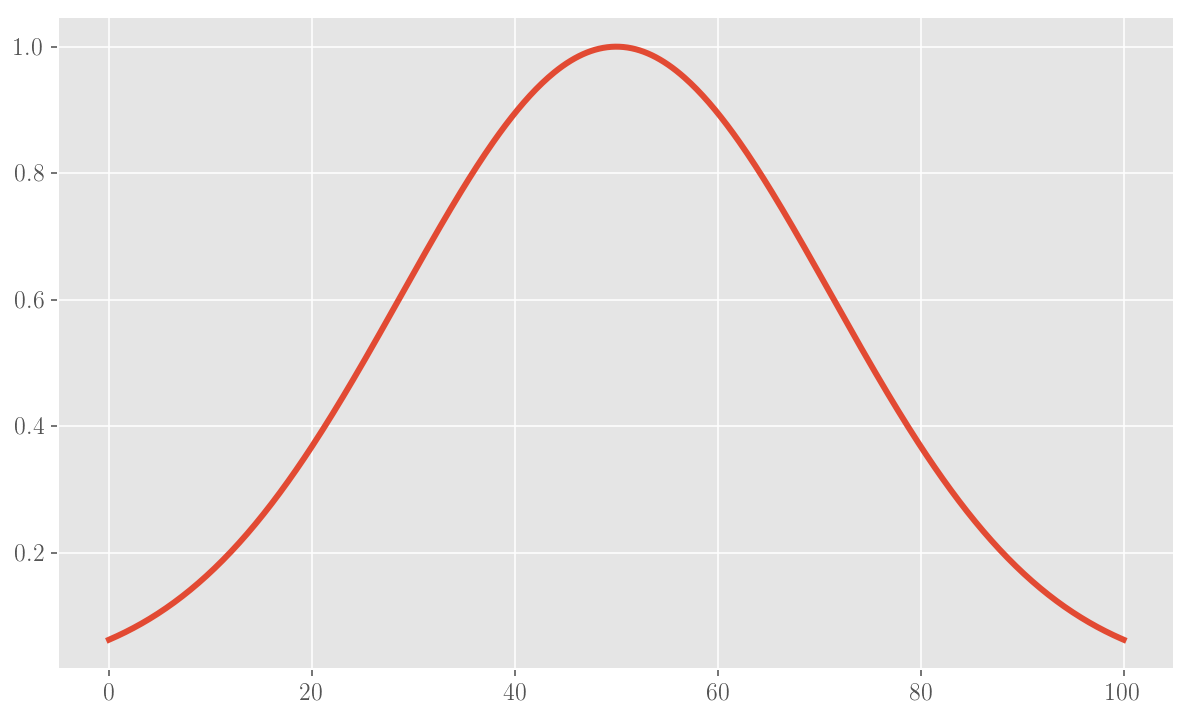

In [3]:
x = np.linspace(0, 100, num=500)
g = np.exp(-(x-50)**2/30**2)

plt.plot(x, g)
plt.show();

This way points in the middle of the scale are given higher possibility to vary from the line. So these are the $y$ points:

In [4]:
y = [2 * i + np.random.randint(-np.exp(-(i-50)**2/30**2)*30, np.exp(-(i-50)**2/30**2)*30) for i in x]

Let's fit an OLS on these data (using [`statsmodels`](http://statsmodels.sourceforge.net/stable/)). We see that the slope we obtain is $\approx 1.99$ and the $R^2$ comes as 0.99.

In [7]:
# fit an OLS, just the slope (intercept is 0)
fit_result = sm.OLS(y, x).fit()
fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 5.440e+04
Date:                Tue, 07 Mar 2017   Prob (F-statistic):               0.00
Time:                        21:31:23   Log-Likelihood:                -1910.3
No. Observations:                 500   AIC:                             3823.
Df Residuals:                     499   BIC:                             3827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9959      0.009    233.242      0.000       1.979       2.013
==============================================================================
Omnibus:                        4.033   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.133   Jarque-Bera (JB):                4.479
Skew:                           0.096   Prob(JB):                        0.107
Kurtosis:                       3.422   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's plot both the data points and the fitting line: the fact that residuals are larger in the middle is quite visible.

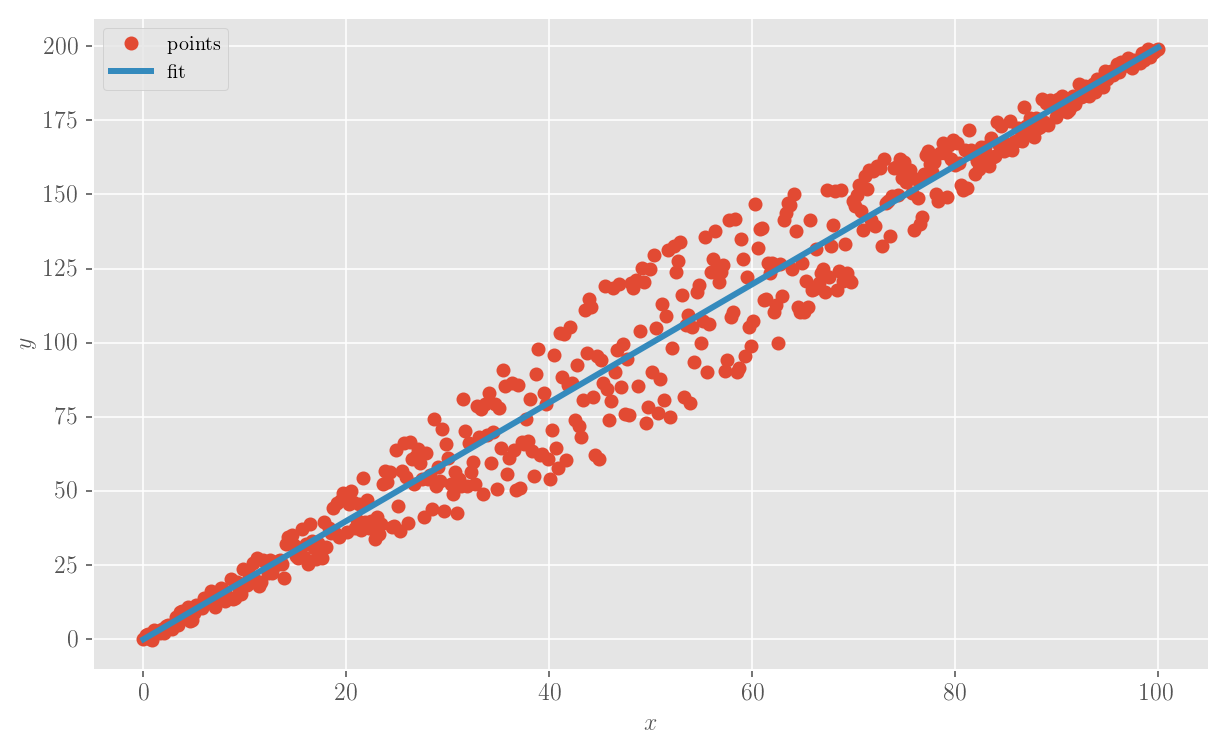

In [8]:
plt.plot(x, y, 'o', label='points')
plt.plot(x, fit_result.params * x, label='fit')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show();

Residuals are, as expected, normally centered around $0$:

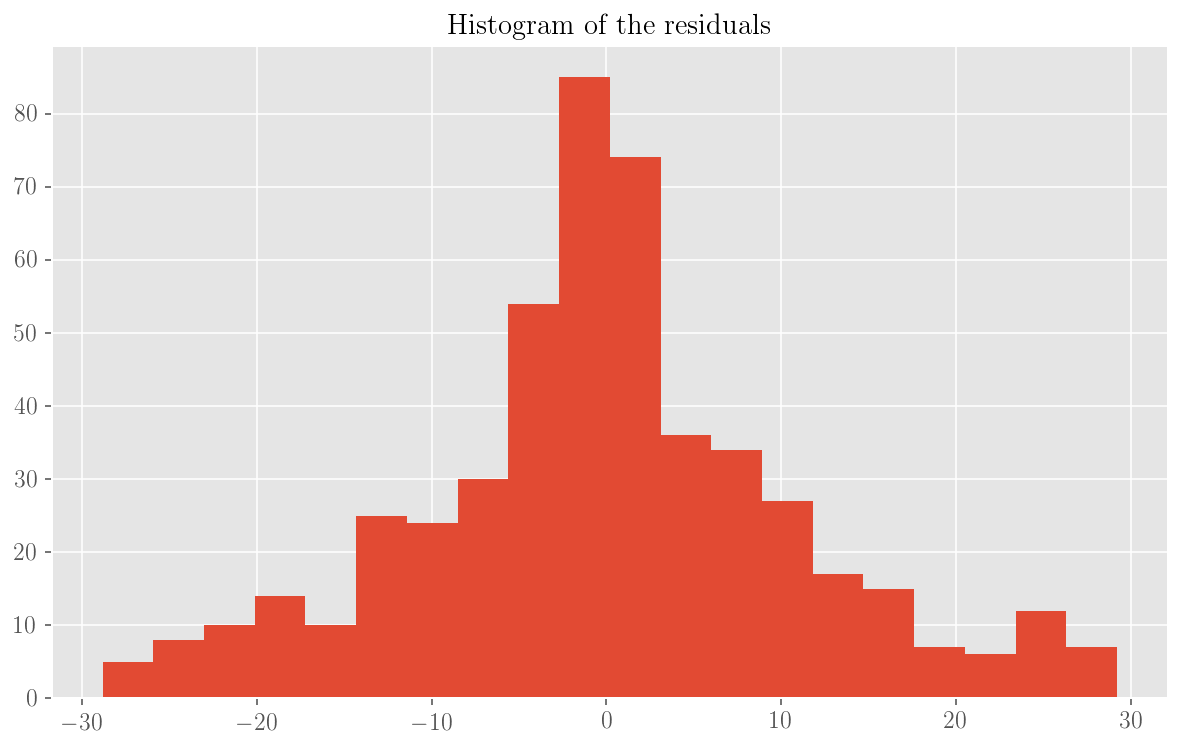

In [9]:
plt.hist(fit_result.resid, bins=20)
plt.title('Histogram of the residuals')
plt.show();

In this silly dataset, residuals are normally distributed but they display a pattern with the independent variable (well, _we_ have imposed it!). In fact, if we plot a scatter of them against $x$, this appears very clearly: points in the middle have larger errors. 

This because we have imposed this feature to our data so it is an obvious "discovery", but in a general case the analysis of the trend of residuals can lead to interesting considerations which the sole histogram would hide. See this treatment [[1]](#1) for a vivid example. 

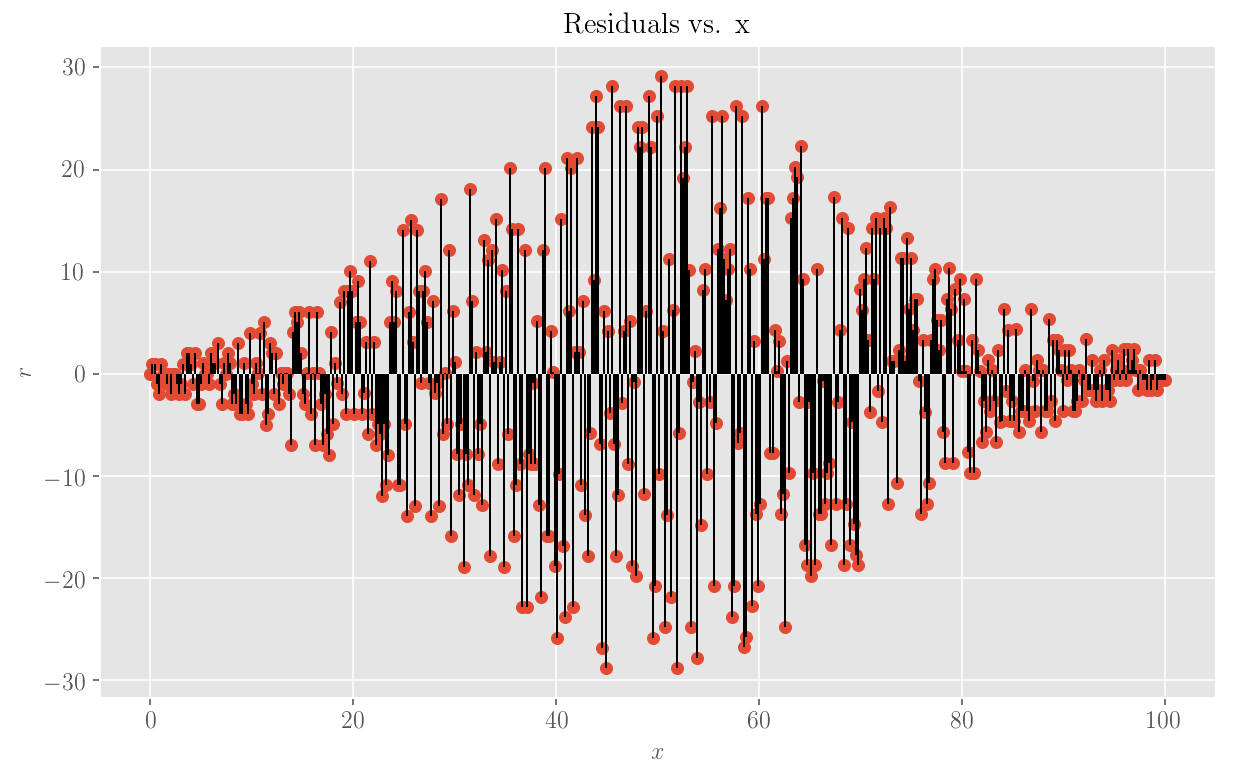

In [10]:
plt.scatter(x, fit_result.resid)
plt.vlines(x, 0, fit_result.resid, lw=1)
plt.xlabel('$x$')
plt.ylabel('$r$')
plt.title('Residuals vs. x')
plt.show();

The article in [[1]](#1) reports a very nice discussion over all this.

### With some real data

We'll now use one of the datasets readily vailable in `statsmodels` to perform an OLS. In particular, let's choose the dataset named [_Scotland_](http://statsmodels.sourceforge.net/0.5.0/datasets/generated/scotland.html), which contains data about the devolution referendum held in Scotland in 1997: the question to the voters was about the creation of a Scottish Parliament with its own powers, specifically over taxation.

There are $32$ rows in the data, one for each county and $8$ attributes, the dependent variable is the proportion of YES votes obtained. The attributes are:

* _COUTAX_: ££ of council tax
* _UNEMPF_: percentage of total unemployment benefits claims from females
* _MOR_: standardized mortality rate (UK one set to 100)
* _ACT_: percentage of labor force participation
* _GDP_: GDP
* _AGE_: percentage of children aged 5 to 15
* *COUTAX_FEMALEUNEMP*: _COUTAX * UNEMPF_

In [9]:
dataset = sm.datasets.scotland.load_pandas()
df = dataset.data

This is a sample of the dataset:

In [10]:
df.head()

,YES,COUTAX,UNEMPF,MOR,ACT,GDP,AGE,COUTAX_FEMALEUNEMP
0,60.3,712.0,21.0,105.0,82.4,13566.0,12.3,14952.0
1,52.3,643.0,26.5,97.0,80.2,13566.0,15.3,17039.5
2,53.4,679.0,28.3,113.0,86.3,9611.0,13.9,19215.7
3,57.0,801.0,27.1,109.0,80.4,9483.0,13.6,21707.1
4,68.7,753.0,22.0,115.0,64.7,9265.0,14.6,16566.0


And this is the basic statistics and correlations:

In [11]:
df.describe()
df.corr()

,YES,COUTAX,UNEMPF,MOR,ACT,GDP,AGE,COUTAX_FEMALEUNEMP
count,32.000000,32.000000,32.000000,32.000000,32.00000,32.000000,32.000000,32.000000
mean,61.440625,744.375000,22.665625,113.906250,79.10000,10057.500000,14.212500,16723.978125
std,7.970747,110.493249,2.586268,10.611495,5.60334,1676.263548,0.903666,2143.153119
min,47.400000,486.000000,18.500000,96.000000,64.70000,8298.000000,11.600000,11275.200000
25%,53.225000,681.500000,20.725000,106.750000,76.70000,9265.000000,13.700000,15820.500000
50%,62.400000,750.000000,22.300000,112.500000,80.20000,9483.000000,14.350000,16821.750000
75%,67.625000,792.250000,23.725000,119.500000,82.55000,9611.000000,14.900000,17928.900000
max,75.000000,982.000000,28.300000,138.000000,87.80000,13566.000000,15.900000,21707.100000


,YES,COUTAX,UNEMPF,MOR,ACT,GDP,AGE,COUTAX_FEMALEUNEMP
YES,1.000000,0.667959,-0.755443,0.765713,-0.653138,-0.044874,0.031545,0.103336
COUTAX,0.667959,1.000000,-0.533699,0.541224,-0.631103,0.116699,-0.339270,0.665339
UNEMPF,-0.755443,-0.533699,1.000000,-0.650944,0.436801,-0.012270,0.096945,0.266741
MOR,0.765713,0.541224,-0.650944,1.000000,-0.433093,-0.132053,0.150160,0.011768
ACT,-0.653138,-0.631103,0.436801,-0.433093,1.000000,0.157083,0.186724,-0.335845
GDP,-0.044874,0.116699,-0.012270,-0.132053,0.157083,1.000000,-0.290686,0.117110
AGE,0.031545,-0.339270,0.096945,0.150160,0.186724,-0.290686,1.000000,-0.338725
COUTAX_FEMALEUNEMP,0.103336,0.665339,0.266741,0.011768,-0.335845,0.117110,-0.338725,1.000000


Using all the attributes, an OLS fit yields a very high $R^2$:

In [12]:
fit_result = sm.OLS(dataset.endog, dataset.exog).fit()
fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    YES   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     952.4
Date:                Sat, 04 Mar 2017   Prob (F-statistic):           1.03e-28
Time:                        08:57:53   Log-Likelihood:                -88.007
No. Observations:                  32   AIC:                             190.0
Df Residuals:                      25   BIC:                             200.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
COUTAX                 0.0496      0.036      1.381      0.179      -0.024       0.124
UNEMPF                 0.0972      1.154      0.084      0.934      -2.279       2.473
MOR                    0.2738      0.117      2.347      0.027       0.034       0.514
ACT                   -0.2526      0.178     -1.417      0.169      -0.620       0.114
GDP                    0.0004      0.001      0.737      0.468      -0.001       0.001
AGE                    1.9436      1.058      1.837      0.078      -0.235       4.122
COUTAX_FEMALEUNEMP    -0.0012      0.002     -0.675      0.506      -0.005       0.003
==============================================================================
Omnibus:                        0.226   Durbin-Watson:                   1.665
Prob(Omnibus):                  0.893   Jarque-Bera (JB):                0.409
Skew:                           0.140   Prob(JB):                        0.815
Kurtosis:                       2.522   Cond. No.                     3.58e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This is the histogram of residuals (note that the number of points is quite small):

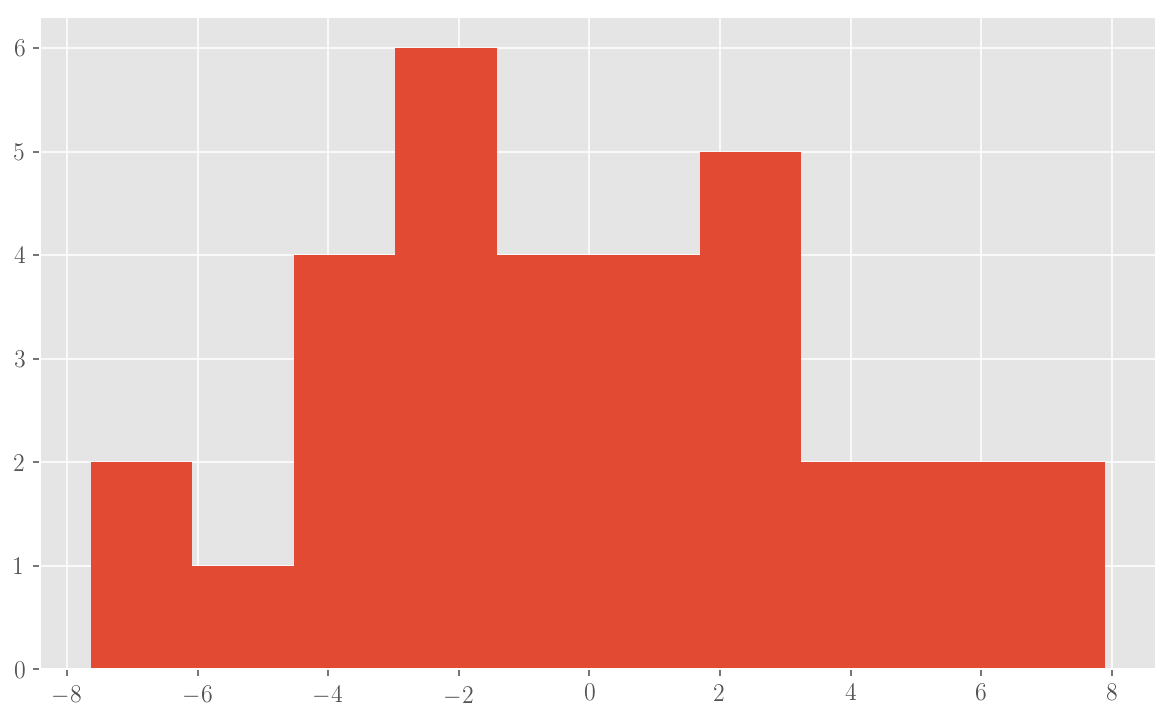

In [13]:
plt.hist(fit_result.resid, bins=10)
plt.show();

Clearly we cannot reproduce the residual plot we did above because we have a matrix of independent variables in this case and not a 1-dimensional array.

## Which points are "influential"?

### The projection matrix

A data point is _influent_ in a regression if any changes to it would sensibly modify the regression. The influence is quantified via the _projection matrix_ (Wikipedia gives a nice overview [[2]](#2)), also called _influence matrix_ or _hat matrix_, which is matrix $P$ such that 

$$
\mathbf{\hat y} = \mathbf{P y} \ ,
$$

where $\mathbf{\hat y}$ is the fitted dependent variable and $\mathbf{y}$ is the observed dependent variable. You see why the name "hat matrix".

Because in a linear model $\mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \mathbf{\epsilon}$ we have

$$
\boldsymbol{\hat \beta} = (\mathbf{X}^t \mathbf{X})^{-1} \mathbf{X}^t \mathbf{y} \ ,
$$

where $\boldsymbol{\hat \beta}$ are the estimated parameters such that $\mathbf{\hat y} = \mathbf{X} \boldsymbol{\hat \beta}$, it follows that

$$
\mathbf{P} = \mathbf{X} (\mathbf{X}^t \mathbf{X})^{-1} \mathbf{X}^t \ .
$$

The diagonal elements in $\mathbf{P}$ are called the *leverages*:

$$
l_i = p_{ii} = \frac{\partial \hat y_i}{\partial y_i}
$$

Leverages quantify the influence of each point in the dataset.

The projection matrix is idempotent:

$$
\mathbf{P}^2 = \mathbf{X} (\mathbf{X}^t \mathbf{X})^{-1} \mathbf{X}^t \mathbf{X} (\mathbf{X}^t \mathbf{X})^{-1}  \mathbf{X}^t = \mathbf{X} (\mathbf{X}^t \mathbf{X})^{-1} (\mathbf{X}^t \mathbf{X}) (\mathbf{X}^t \mathbf{X})^{-1}  \mathbf{X}^t = \mathbf{X} (\mathbf{X}^t \mathbf{X})^{-1} \mathbf{X}^t = \mathbf{P} \ ,
$$

a property which will come in handy in the following. More properties and detailed proofs around the projection matrix can be found in [[3]](#3).

### Studentising the residuals

"Studentising" (from [W S Gosset, aka "Student"](https://en.wikipedia.org/wiki/William_Sealy_Gosset)) the residuals is a way to normalise them to a measure of their error in such a way that they are rendered comparable to one another. The idea is that residuals are *estimates* of the error, so simply dividing them by their sample standard deviation would not be the best of ideas. A clean way has been provided by Mr. Student and it relies on the projection matrix.

Now the residual is expressed by

$$
\mathbf{r} = \mathbf{y} - \mathbf{\hat y} = (\mathbb{1} - \mathbf{P}) \mathbf{y} \ ,
$$

and we want to compute an estimate of its variance.

Because $Var[\mathbf{X a}] = \mathbf{X} Var[\mathbf{a}] \mathbf{X}^t$ (see [here](../../probability/moments.ipynb#Variance-of-a-matrix-of-constant-times-a-random-vector) for the proof) it follows that the variance of the residuals is given by (we are using the idempotence of the projection matrix):

$$
Var[\mathbf{r}] =  (\mathbb{1} - \mathbf{P}) Var[\mathbf{y}] (\mathbb{1} - \mathbf{P})^t =  \sigma^2 (\mathbb{1} - \mathbf{P})^2 =  \sigma^2 (\mathbb{1} - \mathbf{P}) \ ,
$$

hence 

$$
Var[r_i] = \sigma^2 (1 - l_i)
$$

where $\sigma^2$ is the variance of the independent observed variables. 

Studentised residuals are obtained dividing the residual by their standard deviation so calculated:

$$
s_i = \frac{r_i}{\sigma \sqrt{(1-l_i)}}
$$

### The influence plot

The influence plot is obtained by displaying the studentised residuals in a regression against their leverage. This way, in a diagnosis effort, it can be visually monitored which points have the highest influence on the regression itself.

`statsmodels` makes everything super-easy as it has an API for plotting this data directly, which in the case of our data from above leads to (the size of the bubbles is given by [Cook's distance](https://en.wikipedia.org/wiki/Cook%27s_distance)):

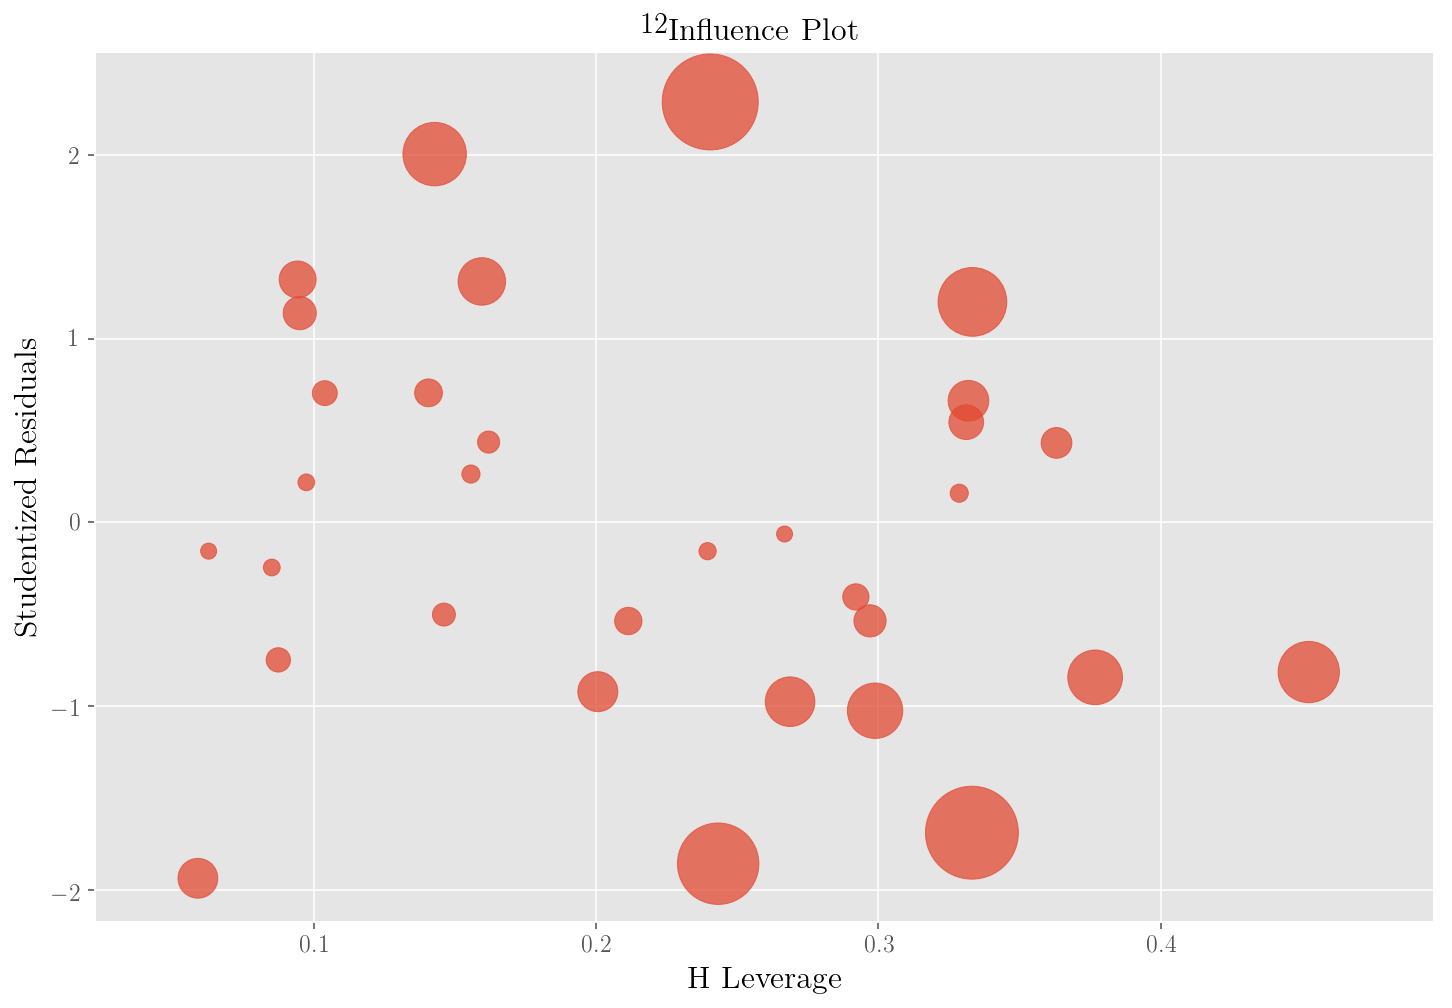

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(fit_result, ax=ax, criterion="cooks")
plt.show()

What we see here is that there are points whose (studentised) residuals are not that high but which exercise a certain influence on the regression, so that removing/changing them would lead to a different outcome. 

## References

1. <a name="1"></a> D J Wheeler, [Should residuals be normal?](http://www.qualitydigest.com/inside/quality-insider-article/should-residuals-be-normal.html)
2. <a name="2"></a> [Wikipedia on the projection matrix](https://en.wikipedia.org/wiki/Projection_matrix)
3. <a name="3"></a> C E Ginestet, [Hat Matrix: Properties and Interpretation](http://math.bu.edu/people/cgineste/classes/ma575/p/w5_1.pdf), *Boston University lecture class*
4. <a name="4"></a> [A worked example in R](http://www.stat.columbia.edu/~martin/W2024/R7.pdf)